# Sentiment Analysis of Tweets using Logistic Regression

## 2021665 - Tahir Muzaffar

## Importing Necessary Libraries

In [11]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

## Loading Data

In [2]:
train = pd.read_csv('train.csv')
print("Training Set:", train.columns, train.shape, len(train))
test = pd.read_csv('test.csv')
print("Test Set:", test.columns, test.shape, len(test))

Training Set: Index(['id', 'label', 'tweet'], dtype='object') (31962, 3) 31962
Test Set: Index(['id', 'tweet'], dtype='object') (17197, 2) 17197


## Cleaning the Text Data

In [3]:
# Text cleaning function
def clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df

# Clean train and test datasets
test_clean = clean_text(test, "tweet")
train_clean = clean_text(train, "tweet")

## Visualizing Class Distribution Before Balancing

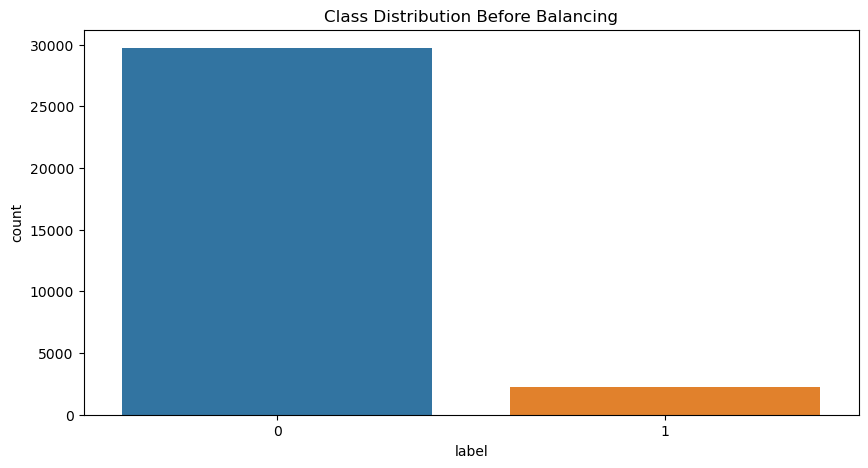

In [4]:
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=train_clean)
plt.title('Class Distribution Before Balancing')
plt.show()

## Balancing the Dataset

In [17]:
train_majority = train_clean[train_clean.label==0]
train_minority = train_clean[train_clean.label==1]
train_minority_upsampled = resample(train_minority, 
                                 replace=True,    
                                 n_samples=len(train_majority),   
                                 random_state=123)
train_upsampled = pd.concat([train_minority_upsampled, train_majority])

## Visualizing Class Distribution After Balancing

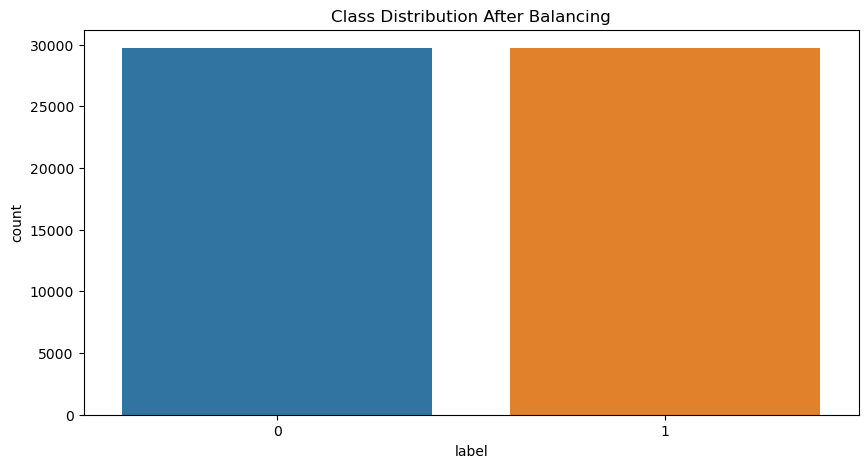

In [16]:
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=train_upsampled)
plt.title('Class Distribution After Balancing')
plt.show()

## Visualizing Word Clouds for Each Class

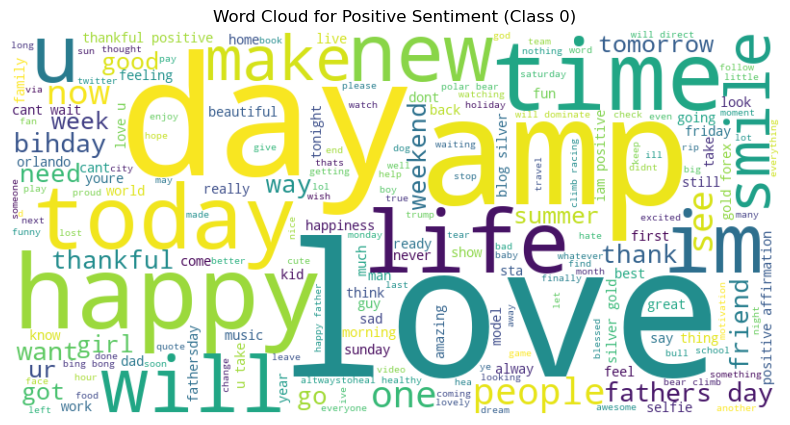

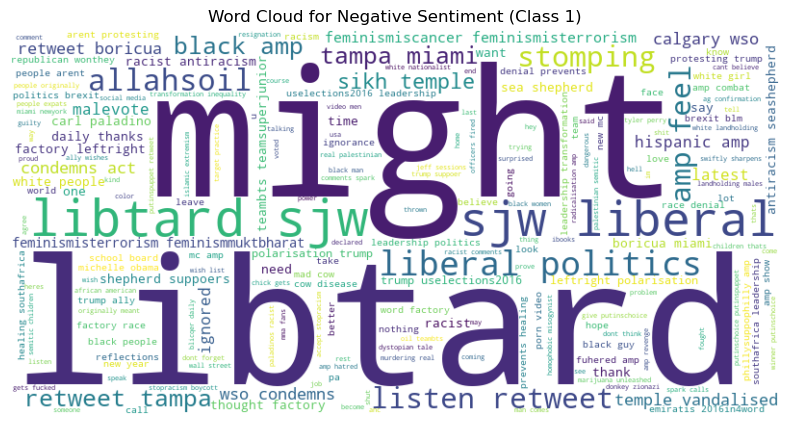

In [15]:
# Generate word clouds
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

generate_word_cloud(train_upsampled[train_upsampled.label == 0]['tweet'], 'Word Cloud for Positive Sentiment (Class 0)')
generate_word_cloud(train_upsampled[train_upsampled.label == 1]['tweet'], 'Word Cloud for Negative Sentiment (Class 1)')

## Building the Model Pipeline using Logistic Regression

In [18]:
# Define the machine learning pipeline with Logistic Regression
pipeline_logreg = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('logreg', LogisticRegression()),
])

# Split the dataset into training and test sets with an 80-20 split
X_train, X_test, y_train, y_test = train_test_split(
    train_upsampled['tweet'], 
    train_upsampled['label'],
    test_size=0.2,
    random_state=0)

# Train the model
model = pipeline_logreg.fit(X_train, y_train)
y_predict = model.predict(X_test)

## Evaluating the Model with F1 Score and Confusion Matrix

F1 Score:  0.974974974974975


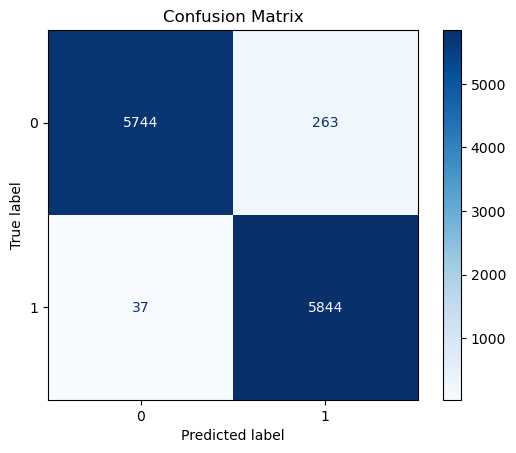

In [19]:
# Calculate F1 Score
f1 = f1_score(y_test, y_predict)
print("F1 Score: ", f1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Visualizing with Receiver Operating Characteristic (ROC) Curve

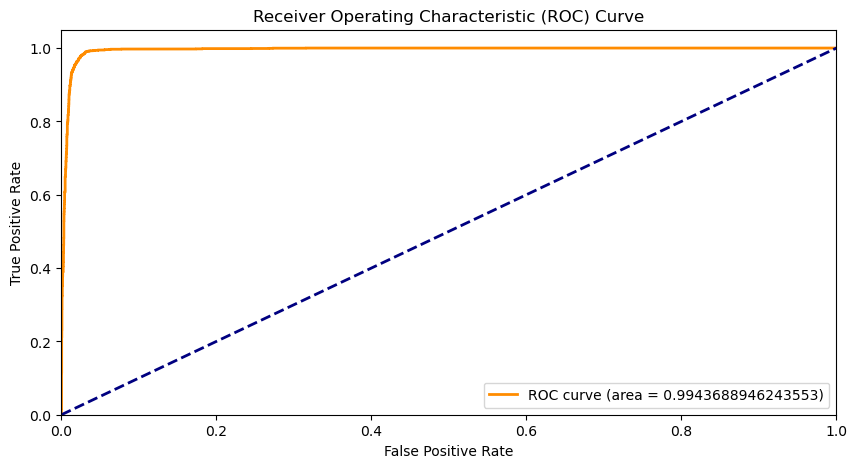

In [26]:
y_prob = model.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()